In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.model_selection import train_test_split

In [43]:
data = pd.read_csv('TotalConsumption.csv')
data['TotalConsumption'] = data['Value_NE5'] + data ['Value_NE7']
data = data.drop(columns=['Value_NE5', 'Value_NE7'])
data['Timestamp'] = pd.to_datetime(data['Timestamp'], utc=True)
data.set_index('Timestamp', inplace=True)
# data = data.resample('H').sum(min_count=1)
data = data.resample('D').sum(min_count=1) #sum/aggregate over a day, to get daily data series. Needs at least on data point per day.
data = data.sort_index()
data['Covid'] = 0
data.loc[(data.index >= '2020-02-01') & (data.index <= '2021-06-01'), 'Covid'] = 1
# data = data.loc[data.index >= '2019-01-01']
# data['TimeIndex'] = np.arange(len(data))
# data = data.drop(columns=['TimeIndex'])

In [44]:
series = TimeSeries.from_dataframe(df=data, value_cols='TotalConsumption')

The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


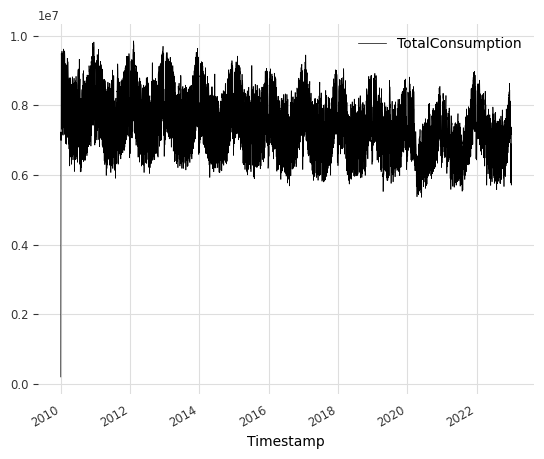

In [45]:

series.plot(linewidth=0.5,alpha=0.5)

In [46]:
train, test = train_test_split(series, test_size=0.3)

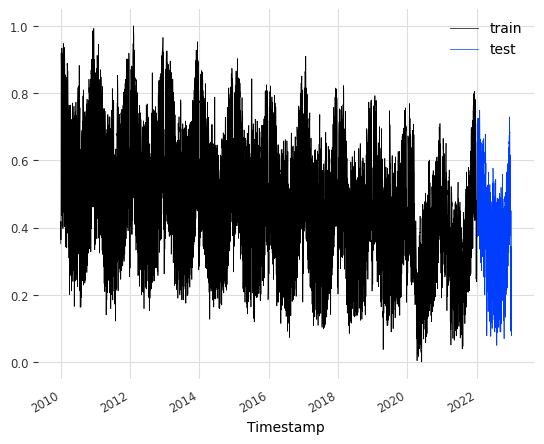

In [54]:
train.plot(linewidth=0.5,alpha=0.3, label="train")
test.plot(linewidth=0.5,alpha=0.3, label="test")

Data

The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


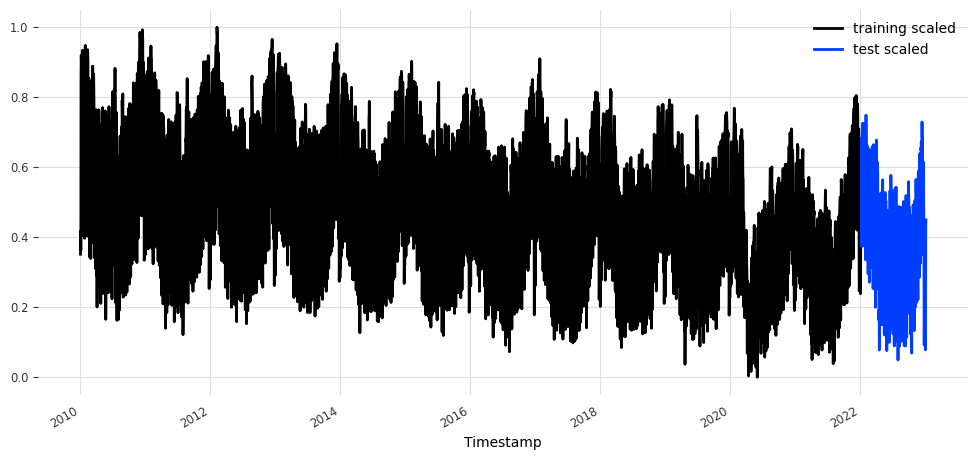

In [48]:
series_scaler = Scaler()
series = TimeSeries.from_dataframe(df=data, value_cols='TotalConsumption')
series = series[1:]

series_unsc = series
series = series_scaler.fit_transform(series)

split_time = 365
train, test = series[:-split_time], series[-split_time:-1]
train_unsc, test_unsc = series_unsc[:-split_time], series_unsc[-split_time:-1]

plt.figure(101, figsize=(12, 5))
train.plot(label='training scaled')
test.plot(label='test scaled')
plt.legend()

Covariates

The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


Text(0.5, 1.0, 'Covariates (Covid)')

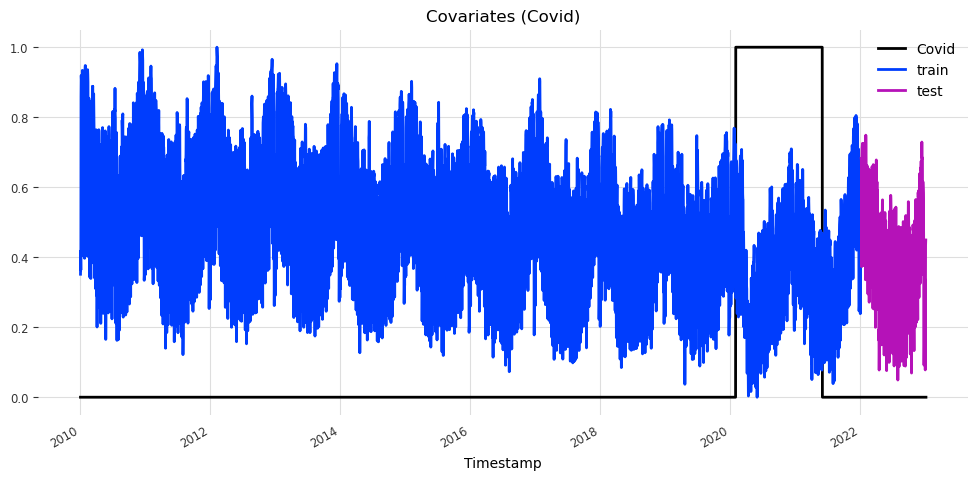

In [49]:
covid = TimeSeries.from_dataframe(df=data, value_cols='Covid')
covid = covid[1:] # it's somehow longer than the others
year    = datetime_attribute_timeseries(series, attribute="year")
month   = datetime_attribute_timeseries(series, attribute="month")
weekday = datetime_attribute_timeseries(series, attribute="weekday")

future_scaler      = Scaler()
past_scaler        = Scaler()
future_only_scaler = Scaler()
past_only_scaler   = Scaler()

### future and past
future_covariates = year.stack(month).stack(weekday)
past_covariates = covid
future_covariates = future_scaler.fit_transform(future_covariates)
past_covariates = past_scaler.fit_transform(past_covariates)

### future only
future_only_covariates = year.stack(month).stack(weekday).stack(covid)
future_only_covariates = future_only_scaler.fit_transform(future_only_covariates)

### past only
past_only_covariates = year.stack(month).stack(weekday).stack(covid)
past_only_covariates = past_only_scaler.fit_transform(past_only_covariates)


plt.figure(101, figsize=(12, 5))
past_covariates.plot()
train.plot(label='train')
test.plot(label='test')
plt.title("Covariates (Covid)")

In [50]:
import warnings
warnings.filterwarnings('ignore')

In [51]:
from darts.models import (
    NaiveSeasonal,
    Prophet,
)
from darts.metrics import mape, mae

NaiveSeasonal

642073.7032683435
8.884652376872557


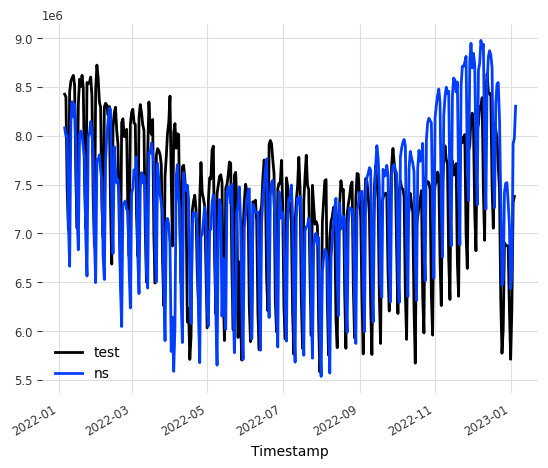

In [52]:
ns = NaiveSeasonal(K=365)
ns.fit(train_unsc)
pred_ns = ns.predict(365)
test_unsc.plot(label='test')
pred_ns.plot(label='ns')

print(mae(test_unsc, pred_ns))
print(mape(test_unsc, pred_ns))

15:26:28 - cmdstanpy - INFO - Chain [1] start processing
15:26:29 - cmdstanpy - INFO - Chain [1] done processing


291459.70824185037
4.065678736127303


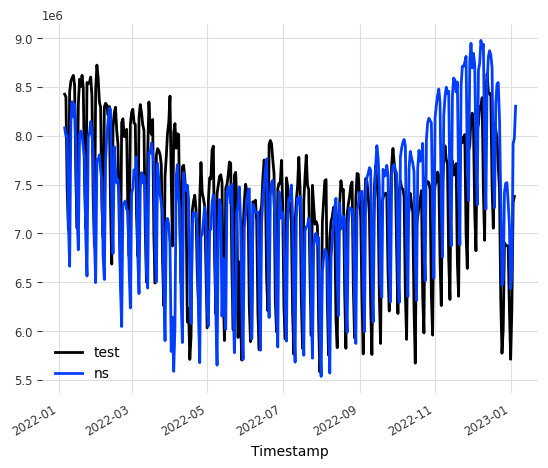

In [53]:
pt = Prophet()
pt.fit(train_unsc)
pred_pt = pt.predict(365)
test_unsc.plot(label='test')
pred_ns.plot(label='ns')

print(mae(test_unsc, pred_pt))
print(mape(test_unsc, pred_pt))